In [ ]:
from geometry_metrics import compute_spectral_entropy, cosine_similarity_matrix, sliding_window, calculate_angles
from se_correlation import encode_labelset, compute_entropies
import json
import numpy as np
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

def UMAP_projection(embeddings, random_seed = 42):
    reducer = umap.UMAP(random_state=random_seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

In [ ]:
import warnings
# Suppress UMAP warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [15]:
import clip
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading CLIP ViT-L/14@336px...")
#Force the model to use float32:
model = clip.load("ViT-L/14@336px", jit=False, device=torch.device("cpu"))[0].to(device)

Loading CLIP ViT-L/14@336px...


In [55]:
pca = PCA(n_components=2)
Dataset = "coil100" 

embedding_path = f"Embeddings/{Dataset}.json"
label_path = f"Data/{Dataset}/labels.json"

with open(embedding_path, "r", encoding="utf-8") as f:
    embedding_dict = json.load(f)["rot"]

for obj in embedding_dict:
    embedding_dict[obj] = np.array([embedding_dict[obj][key] for key in sorted(embedding_dict[obj].keys())], dtype=np.float32)

In [46]:
Dataset = "coil100" 
label_path = f"Data/{Dataset}/labels.json"
with open(label_path, "r", encoding="utf-8") as f:
        label_idx_dict = json.load(f)
 
label_names = list(label_idx_dict.keys())
text_features = encode_labelset(label_names, model, device)

Encoding Labelset: 100%|██████████| 9/9 [00:33<00:00,  3.75s/it]


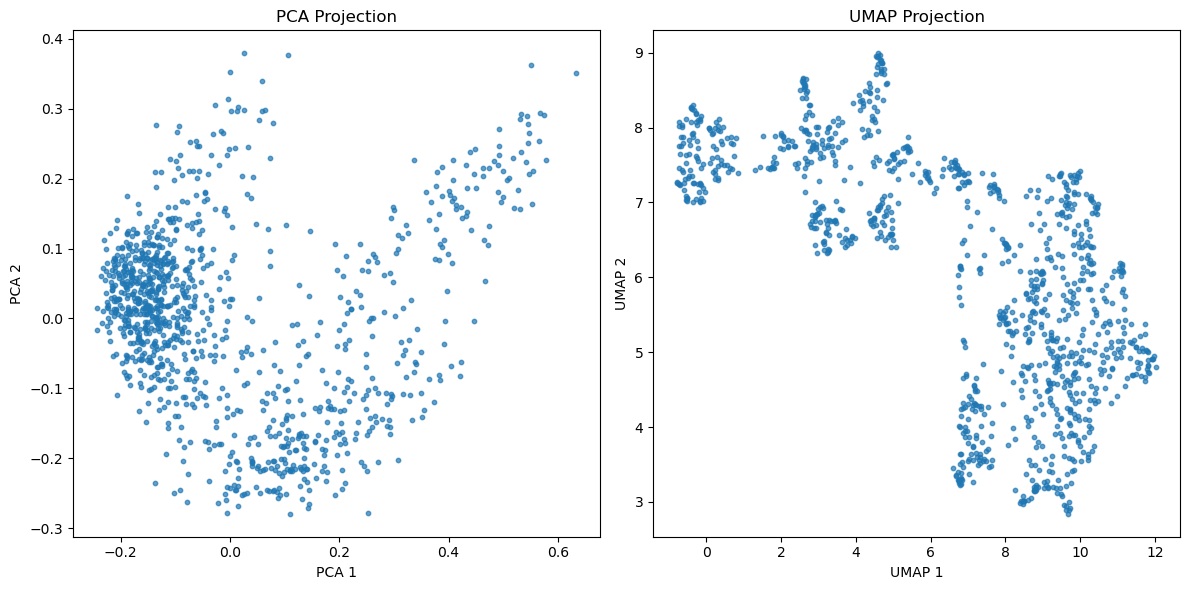

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PCA plot
axes[0].scatter(PCA_text[:, 0], PCA_text[:, 1], s=10, alpha=0.7)
axes[0].set_title("PCA Projection")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# UMAP plot
axes[1].scatter(UMAP_text[:, 0], UMAP_text[:, 1], s=10, alpha=0.7)
axes[1].set_title("UMAP Projection")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

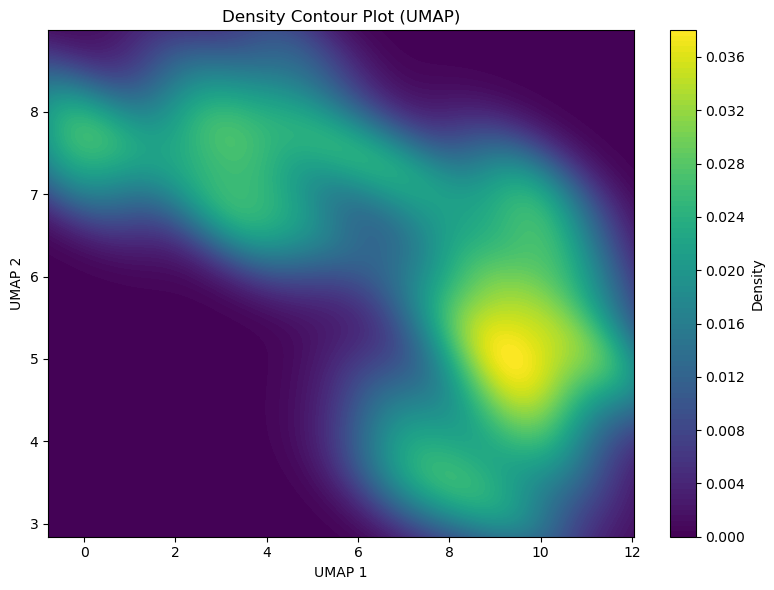

In [60]:

key = "UMAP"
dict_ = {"UMAP": UMAP_text, "PCA": PCA_text}
dict_[key]

data = dict_[key].T  # shape -> (2, N) for gaussian_kde
kde = gaussian_kde(data)
x_min, x_max = data[0].min(), data[0].max()
y_min, y_max = data[1].min(), data[1].max()

# Grid for KDE
x_grid, y_grid = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(positions).reshape(x_grid.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, density, levels = 100, cmap="viridis")
#plt.scatter(data[0], data[1], s=5, color="white", alpha=0.6) #point overlay
plt.title(f"Density Contour Plot ({key})")
plt.xlabel(f"{key} 1")
plt.ylabel(f"{key} 2")
plt.colorbar(label="Density")
plt.tight_layout()
plt.show()

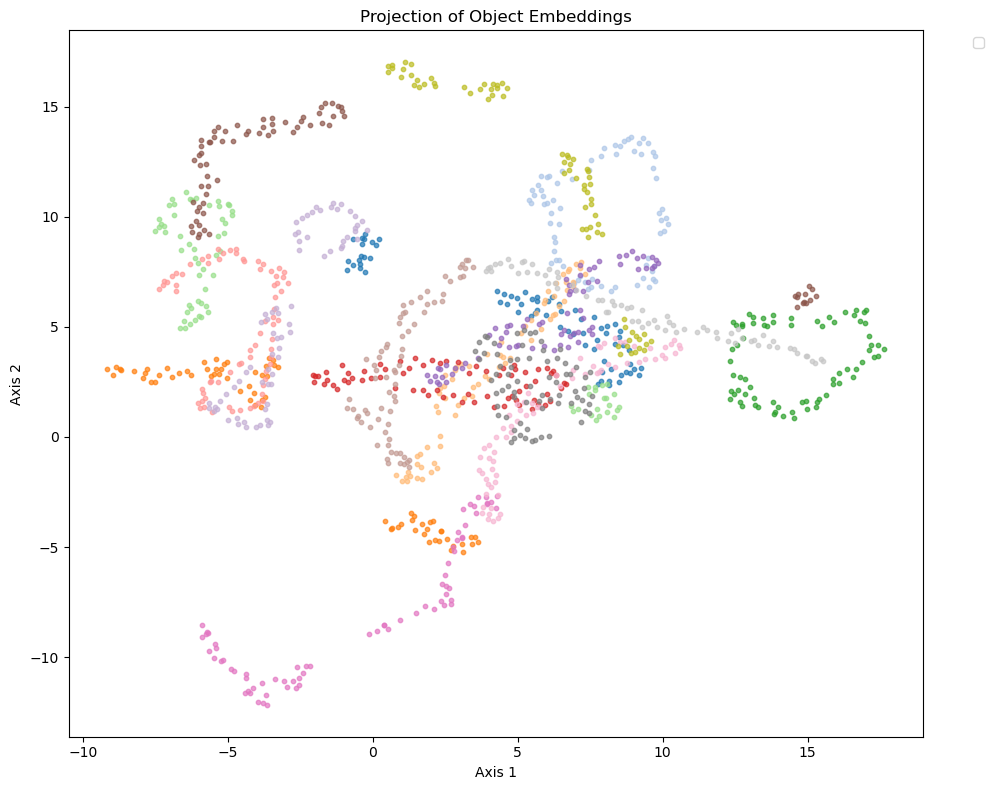

In [ ]:
all_embeddings = []
labels = []

for i, (obj_name, embedding_matrix) in enumerate(embedding_dict.items()):
    projected = UMAP_projection(embedding_matrix, random_seed=42)
    #projected = pca.fit_transform(embedding_matrix)
    all_embeddings.append(projected)
    labels.extend([obj_name] * projected.shape[0])

all_embeddings = np.vstack(all_embeddings)
labels = np.array(labels)

# Assign a unique color to each object
unique_labels = sorted(set(labels))
label_to_color = {label: cm.tab20(i % 20) for i, label in enumerate(unique_labels)}  # up to 20 colors

# Plot
plt.figure(figsize=(10, 8))
for label in unique_labels:
    idxs = labels == label #ved ikke lige hvad der sker her
    plt.scatter(all_embeddings[idxs, 0], all_embeddings[idxs, 1],
                color=label_to_color[label], s=10, alpha=0.7)

plt.title("Projection of Object Embeddings")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Axis 1")
plt.ylabel("Axis 2")
plt.tight_layout()
plt.show()